In [ ]:
!pip install opencv-python matplotlib


In [38]:
#import standard dependencies

#siamese NRR - one shot classification 
import cv2
import os
import random 
import numpy as np
from matplotlib import pyplot as plt

In [39]:
#import tensorflow dependencies - functional API 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten #import several layer types
import tensorflow as tf

#Conv2D - convolutional neural networks 
#Dense - gives a fully connected layer which is seen in most neural networks 
#maxpooling -pool layers together and shrink the average that we have (eg. taking the max average to pass to the next layer) 
#input - define what we're passing through to the model 

In [6]:
Model(inputs=[inputimage, verificationimage] , outputs=[1,0])

# Set GPU Growth

## limiting RAM of how much tensorflow can use
avoid out of memory errors by setting GPU consumption growth <br>
Input image is the **anchor image** <br>
Veriication image is the **positive iage** <br>
the false verification image is the **negative image** <br>

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
gpus # dont have for MacOS

 # Create Folder Structures

In [40]:
#Setup paths

POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
#make the directories

os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

### we have an input image coming from the webcam
### the positive image is what we're expecting 
### implement them into an embedding model which converts our webcam / anchor representation into a data representation 
#### when building the model, we're trying to determine the difference between our anchor and our positive 
#### the **layer** will be our comparison node to detect similarity --> outputs a 1 for verification, 0 for non-verification

#### negative input will also have the same model + embedding layer 
#### the model will learn how to better represent input images to be able to ensure that when we perform our siilarity analysis, that we can classify whether it matches or not match
#### when passed through our distance layer, it will determine siilarity or not

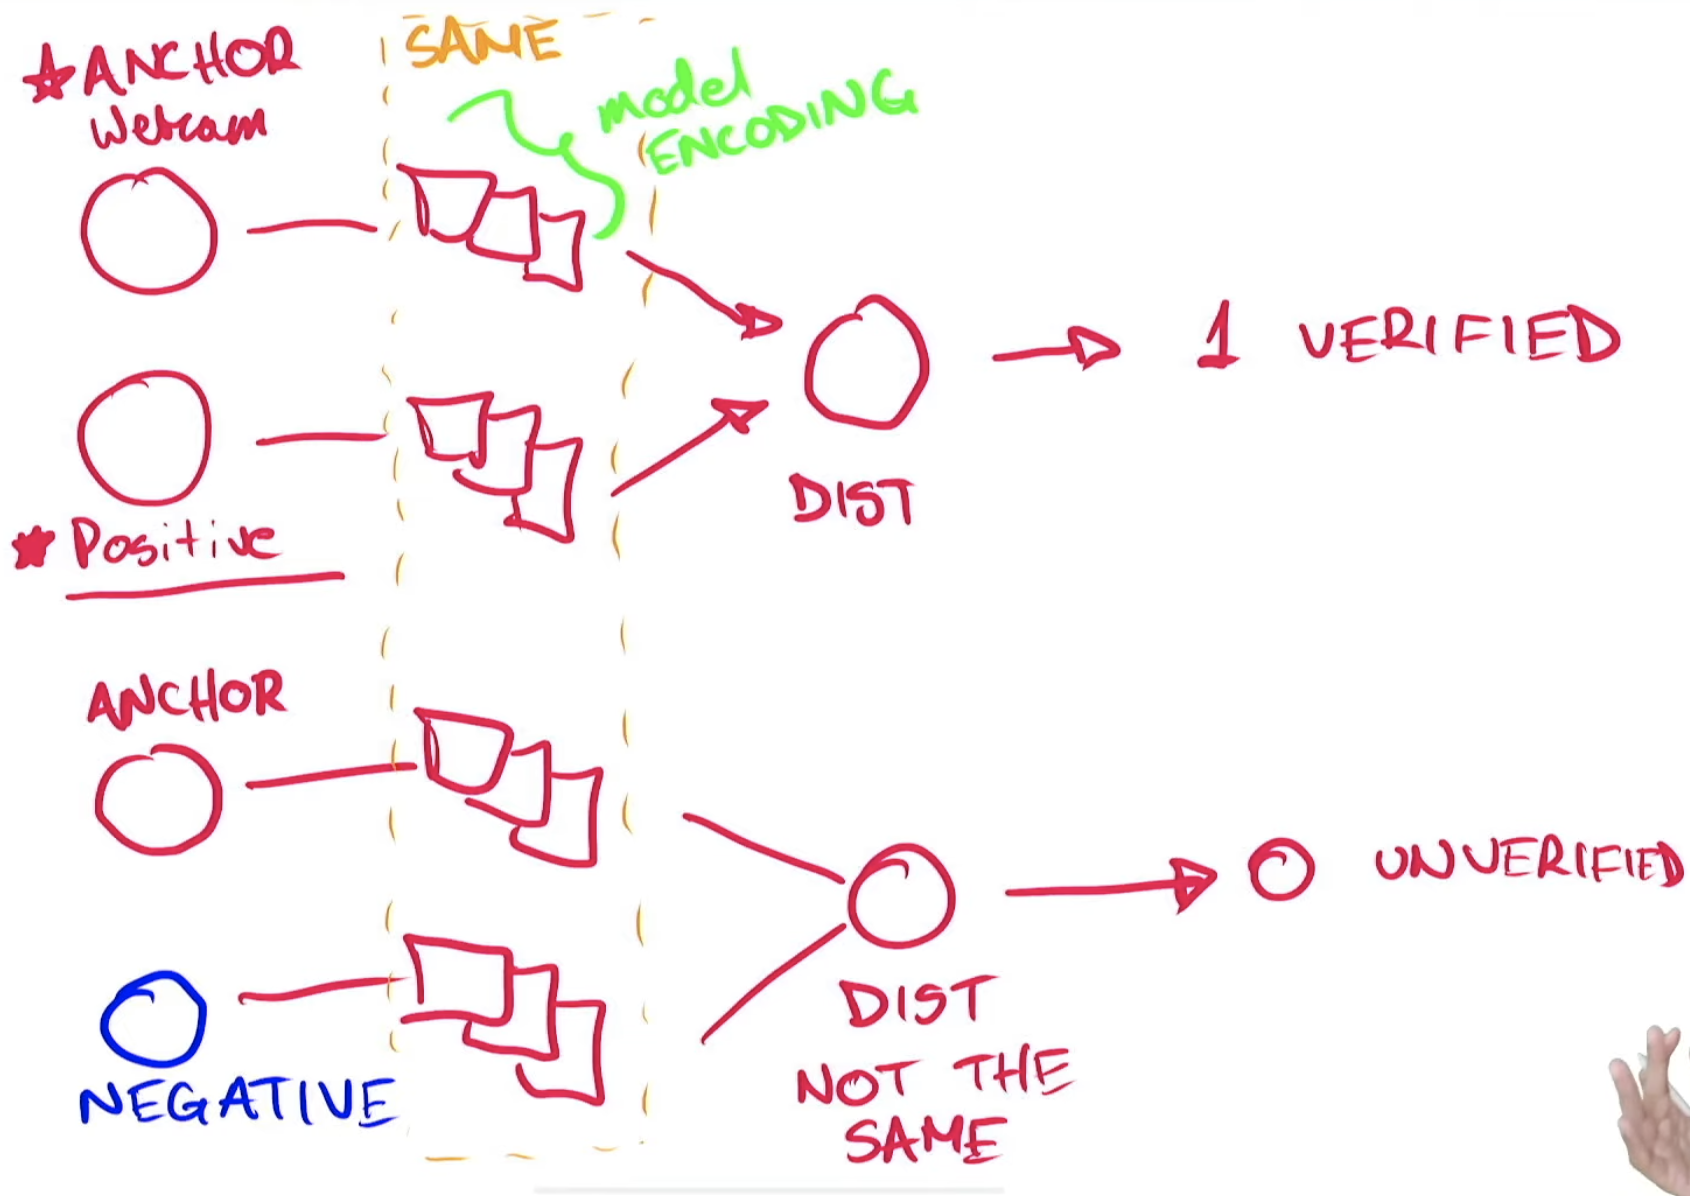

- anchor will come from Webcam via OpenCV <br>
- Positive will come from Webcam via OpenCV <br>
- Negative will come from CFW (open-source dataset) <br>

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# http://vis-www.cs.umass.edu/lfw/

In [ ]:
#uncompress Tar GZ labelled faces in the wild dataset
#!tar -xf: extract the data from the file lgw.tgz
!tar -xf lfw.tgz

#should just uncompress the folder - can do manually 

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file) #pass through lfw, directory and the file name
        NEW_PATH = os.path.join(NEG_PATH, file) #specifying new path by passing through negative path and pass file name
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
os.path.join(NEG_PATH, file)

# 2.2 Collect Postive and Anchor Classes

- lfw dataset images are all 250x250
- when collect anchor and positives, ensure it is 250x250

In [42]:
#import uuid library to generate unique image names
import uuid

In [43]:
os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))

In [46]:
#Access Webcam
cap_device = 0 
cap = cv2.VideoCapture(cap_device) #establish a connection to the webcam
cap.set(cv2.CAP_PROP_FPS, 60)
cfps = int(cap.get(cv2.CAP_PROP_FPS))
while cap.isOpened(): #loop every single frame in webcame
    ret, frame = cap.read() #read a point of capture at the time. unpack the result and get a return value and get a frame - the actual image
    
    #take the resized frame from below as image slice sample
    #cut down frame to 250x250px
    frame = frame[440:440+250,580:580+250, :]
    
    #collect anchors
    #wait 1mi sec, hit a and collect anchor
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #create unique file path
        #store anchor images inside anchor path + create a unique name
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        #pass image and the frame of 250 by 250
        cv2.imwrite(imgname, frame)
        
    
    #collect postives
    #wait 1mi sec, hit a and collect anchor
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #create unique file path
        #store anchor images inside anchor path + create a unique name
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        #pass image and the frame of 250 by 250
        cv2.imwrite(imgname, frame)
        
    #show image back to the screen
    cv2.imshow('Image Collection', frame)
    
    #breaking gracefully.
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
#release the webcam
cap.release()
#close the image show frame. destroy all windows
cv2.destroyAllWindows()

#it will 1 millisecond and check what key is pressed
#when hit q, it will close down our frame 
#hit a = collect anchor
#hit p = collect positive number

In [47]:
#dimension of the image captured
frame 

In [ ]:
frame.shape 
# this is not 250x250 pixels

In [ ]:
#checking the shape of the image dimension 
#when configuring with size
frame[:250,:250, :].shape

In [ ]:
plt.imshow(frame[440:440+250,580:580+250, :])

#start from 440 pixels and end at 440+250 
#needs to be 250x250
#want all three channels with the : in the end --> retains that it is a coloured image

# augment data

In [56]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [ ]:
import os
import uuid

img_path = os.path.join(ANC_PATH, '924e839c-135f-11ec-b54e-a0cec8d2d278.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [58]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.

# 3. Load and Preprocess Images

### 3.1 Get Image Directories

In [59]:
# use the tf.data.Dataset.list_files to grab all the different images in each directory

anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [60]:
dir_test = negative.as_numpy_iterator()

In [61]:
dir_test.next()

In [62]:
#full path to a specific image in our directory 
dir_test.next()

# 3.2 Preprocessing - scale and resize
- write preprocessing function that loads image from directory
- resize it 
- perform some scaling
- from different number --> into 0 and 1

In [ ]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path) #reads the files
    img = tf.io.decode_jpeg(byte_img) #opens the jpg images
    img = tf.image.resize(img, (100,100)) #resize the image by 100*100
    img = img/255.0
    return img

In [49]:
#numpy equivalent of our image
img = preprocess('data/anchor/55f13e6c-aa51-11ed-bd1a-acde48001122.jpg')

In [50]:
#our min is not less than 0 
#our max is not bigger than 255
img.numpy().min()

In [51]:
plt.imshow(img)

In [63]:
#apply the preprocess method over every single example we have in our pos / neg file
dataset.map(preprocess)

# 3.3 create label dataset

In [64]:
#(anchor, positive) => 1,1,1,1,1,
#(anchor, negative) => 0,0,0,0,0

"""
in the video: 
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones_like(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros_like(len(anchor)))))
data = positives.concatenate(negatives)
"""


In [65]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [66]:
#labelled positive at the same time 
#tf.ones(len(anchor))

In [67]:
samples = data.as_numpy_iterator()

In [ ]:
example = samples.next()
#the 1 is the label meaning it is classified as positive

In [69]:
example

# 3.4 Build Train and Test Partition

In [154]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

#inserting the image dimensions and the label (positive / negative)
#load our preprocess function on input + validation + return our label

In [70]:
res = preprocess_twin(*example)
#the star unpacks all the tuple in the data
#this is our preprocess image
#100x100x3 shape

In [75]:
plt.imshow(res[1])

In [76]:
res[2]

In [77]:
#build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [78]:
#training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16) #pass data as 16 images
train_data = train_data.prefetch(8) #preprocess next set of images to avoid bottleneck

#First none value represents the batch

In [163]:
train_samples = train_data.as_numpy_iterator()

In [164]:
train_sample = train_samples.next()

In [166]:
len(train_sample[0])

In [79]:
#testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3)) #take the last 180 images
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [81]:
inp = Input(shape=(100,100,3), name='input_image')

In [82]:
# rectified linear unit 
# outputs the max calue of the output and 0 if it is negative
# ensures that it remains a positive number
c1 = Conv2D(64, (10,10), activation = 'relu')(inp)

In [83]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [84]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [85]:
c3 = Conv2D(128, (4,4), activation='relu')(m2) #128 @ 18x18
m3 = MaxPooling2D(64, (2,2), padding='same')(c3) #128 @ 9x9

In [86]:
c4 = Conv2D(256, (4,4), activation='relu')(m3) #256 @ 6x6
f1 = Flatten()(c4) #multiply 6*6*256 which make f1 equal to 9216
d1 = Dense(4096, activation='sigmoid')(f1)

In [87]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [88]:
mod.summary()

In [89]:
#copying siamese model in the paper
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3) #256 filters of shape 4x4 within activation of relu where pass m3 results
    f1 = Flatten()(c4) #take all outputs of dimension and flatten it
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding') #outputting feature vector of 4096 units

In [90]:
embedding = make_embedding()

In [91]:
#forms the output layer
embedding.summary()

## 4.2 Build Embedding Layer

In [92]:
#custom neural network layer
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    #similarity calculation
    def call(self, input_embedding, validation_embedding): #pass through specific keyword arguments, it will handle them innately
        return tf.math.abs(input_embedding - validation_embedding) 

In [93]:
l1 = L1Dist()

In [94]:
l1(anchor_embedding, validation_embedding) #combine into dense layer and produce our final output

# 4.3 Make Siamese Model

In [95]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [96]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [97]:
siamese_layer = L1Dist()

In [98]:
siamese_layer(inp_embedding, val_embedding) #pass through the inp and val in siamese layer which outputs 4096

In [99]:
distances = siamese_layer(inp_embedding, val_embedding)

In [100]:
classifier = Dense(1, activation='sigmoid')(distances)

In [101]:
classifier #output of shape 1

In [102]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [103]:
siamese_network.summary()

#input + validation image that get combined in the embedding layer and get passed through the l1 dist layer
#combine the dist layer to a dense laer which create a single value

In [104]:
def make_siamese_model():
    
    #anchor image input in the network
    #two kwargs, the name and the shape
    input_image = Input(name='input_img', shape=(100,100,3))
    
    #validation image in the network 
    #two kwargs, the name and the shape
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
#need to take raw inputs to pass to distance layer
    #combinese siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image)) #parse input image into embedding model
    
    #classification layer
    classifier = Dense(1, activation='sigmoid')(distances) #passing through the distances which have a shape of 4096 units to get 1 output value which is either a 1 or a 0
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [105]:
siamese_model = make_siamese_model()

In [106]:
siamese_model.summary()

# 5. Training 

## 5.1 Setup Loss and Optimiser

In [107]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [108]:
#define atom optimiser
opt = tf.keras.optimizers.Adam(1e-4) #1e-4 is learning rate of 0.0001 #save this in checkpoint

## 5.2 Establish Checkpoints

In [109]:
checkpoint_dir = './training_checkpoints' #from current folder, we will move all our saved files in training checkpoint folder
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt') #prefix our checkpoint with ckpt format to add consistency and add a set of unique numbers 01 002 etc
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model) #we will save opt and siamese_model as our set of checkpoints

In [110]:
#reload from checkpoint, use:
#model.load('path_to_checkpoint')

## 5.3 Build Train Step Function
- apply training step per batch
- make a prediction, calculate our loss, calculate our gradients and apply backpropagation

In [111]:
test_batch = train_data.as_numpy_iterator()

In [112]:
batch_1 = test_batch.next()

In [113]:
len(batch_1[0]) #16 anchor images
len(batch_1[2]) #16 in our negative /positive images
len(batch_1[0]) #our possible labels 

In [114]:
X = batch_1[:2]

In [115]:
np.array(X).shape

#batch number, number of images, dimension shape

In [116]:
Y = batch_1[2]

In [117]:
Y

# **tf.losses.BinaryCrossentropy --> bce(ytrue, ypredict)**

In [118]:
@tf.function
def train_step(batch): 
    with tf.GradientTape() as tape: 
        
        #get anchor with positive/negative image
        X = batch[:2]
        #get label
        Y = batch[2]
        
        #forward pass
        yhat = siamese_model(X, training=True)
        #calculate loss
        loss = binary_cross_loss(Y, yhat) 
        print(loss)
        
        #calculate gradients
        grad = tape.gradient(loss, siamese_model.trainable_variables)
        
        
        #calculate updated weights and apply to siamese model
        opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
      
        return loss
    


### ^disadvantages: must define all the progress bars and the loss metrics being output

## 5.4 Build Training Loop
- go through every single batch / epoch and apply training step

In [119]:
def train(data, EPOCHS):
    #loop through epochs + define progress bar
    for epoch in range(1, EPOCHS+1): #increment by 1 else it will start from 0
        print('\n Epoch {}/{}'.format(epoch, EPOCHS)) #print out which epoch we are up to 
        progbar = tf.keras.utils.Progbar(len(data)) #define progbar. increment everytime we go through specific batch
        
    #loop through each batch
    for idx, batch in enumerate(data): #add counter to actual batch
        #run train step 
        train_step(batch)
        progbar.update(idx+1)
        
    #save checkpoint every 10 epochs
    if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## Train Model

In [120]:
EPOCHS = 50

In [121]:
train(train_data, EPOCHS)

# 6. Evaluate Model

In [122]:
#import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [123]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()


## !run here for new batch generation!

In [124]:
test_var = test_data.as_numpy_iterator().next()

In [125]:
len(test_var) 

In [126]:
#make predictions
#use siamese model
y_hat = siamese_model.predict([test_input, test_val]) #pass our input data and validation data. ORDER IS IMPORTANT
y_hat

In [127]:
#parse the results as binary  outcome instead of range of values
#post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat] #does a loop 

In [128]:
#can also be written this way (didnt run)
"""
res = []
for prediction in y_hat:
    if prediction > 0.5:
        res.append(1)
    else:
        res.append(0)
"""

In [129]:
y_true

In [130]:
m = Recall() #create metric object
m.update_state(y_true, y_hat) #calculating the recall value
m.result().numpy() #convert to numpy value + return recall result

In [131]:
m = Precision() #create metric object
m.update_state(y_true, y_hat) #calculating the recall value
m.result().numpy() #convert to numpy value + return recall result

## visualise our results!

In [138]:
import matplotlib.pyplot as plt
#figsize controls how big the plot is represented
plt.figure(figsize=(18,8))

plt.subplot(1,2,1)


plt.imshow(test_input[3]) 

plt.subplot(1,2,2)
plt.imshow(test_val[3])

#render
plt.show()

# 7. Save Model

In [140]:
#save weights
siamese_model.save('siamesemodel.h5')

In [141]:
#reload model
#pass the name first
#load our custom object of our dictionary L1 Distiance layer
#tf.lossesBinaryEntropy """Computes the cross-entropy loss between true labels and predicted labels.

model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [142]:
#make predictions from our reloaded model
model.predict([test_input, test_val])

# 8. Real Time Test

## 8.1 Verifcation Function

- need to access webcam to use as input image
- verify images  against postive samples by looping through them --> one cycle will make 50 predictions
- image passed through neural network which outputs a 1 or 0 


### verifcation threshold
- set a threshold that we count our person in a negative class (50% for example > we count it as a positive sample)
### detection threshold - count the number of classes that surpass verification threshold 
- eg. 30 images that get over 50% 
- 30/50 which will become a detection metric to determine if we have a positive sample 

In [154]:
application_data\verification_images

In [155]:
#loop through images and use them to perform our prediction (50 samples)
#better likelihood of making accurate prediction
os.listdir(os.path.join('application_data', 'verification_images'))

In [160]:
os.path.join('application_data', 'verification_images')

In [161]:
#grab input image from webcam and store in application folder  and call it INPUT_IMAGE.JPG
os.path.join('application_data', 'input_image', 'input_image.jpg')

In [163]:
for image in os.path.join('application_data', 'verification_images'):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

In [164]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verifcation

In [165]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read() #reading our frame and give us frame value to work with
    frame = frame[120:120+250,200:200+250, :] #to get 250x250 dimensions
    
    
    cv2.imshow('Verification', frame)
    
    #verification trigger -- how to trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
       #save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
        #run verification
        #unpack results from function above
        #verify our siamese network
        results, verified = verify(siamese_model, 0.8, 0.9) #verify function above
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [166]:
results

In [ ]:
list(results)

In [ ]:
np.sum(np.squeeze(results) > 0.8)

In [ ]:
1/50 #50 samples - 28% threshold

#it passes, set the new threshold in the verify function 
#results, verified = verify(model, 0.8, 0.7) 
#change the detection thresh to 80%, the verification to 70%

# improve accuracy
- add more verification images
- change the threshold

SyntaxError: invalid syntax (4120041560.py, line 1)